In [14]:
from dotenv import load_dotenv
load_dotenv()

import re
import os, json

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

In [15]:
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_core.tools import tool
from typing import List

#embeddings_model = OllamaEmbeddings(model="qwen2.5:1.5b") 
embeddings_model = OllamaEmbeddings(model="bge-m3:latest")

# menu db 벡터 저장소 로드
menu_db = FAISS.load_local(
    "../../db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# Tool 정의 
@tool
def search_cafe_menu(query: str) -> List[str]:
    """카페 메뉴에서 정보를 검색합니다."""
    docs = menu_db.similarity_search(query, k=6)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 메뉴 정보를 찾을 수 없습니다."

In [16]:
from langchain_community.tools import TavilySearchResults


# Tool 정의 
@tool
def search_web(query: str) -> List[str]:
    """데이터베이스에 존재하지 않는 정보 또는 최신 정보를 인터넷에서 검색합니다."""

    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."

In [17]:
from langchain_openai import ChatOpenAI

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

# 도구 목록
tools = [search_cafe_menu, search_web]

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)

In [18]:

system_prompt = dedent("""
당신은 사용자 질문에 답변하는 카페 도메인에 특화된 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_cafe_menu  
액션 입력: 아메리카노

(도구 실행 후)  
[출처: search_cafe_menu | 스테이크 | ../../db/cafe_db]  
아메리카노 정보: 아메리카노 4,500원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성
""")

In [19]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display
# LangGraph MessagesState 사용
class AgentState(MessagesState):
    pass

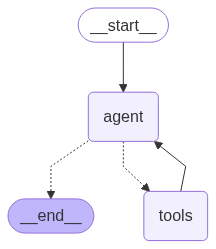

In [20]:
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
# 노드 함수 정의
def call_model(state: AgentState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(AgentState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

graph = builder.compile()

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  search_cafe_menu (call_dyswTpe3USgySccI4nZnUSrS)
 Call ID: call_dyswTpe3USgySccI4nZnUSrS
  Args:
    query: 아메리카노
  search_cafe_menu (call_MObObNu8cUTLlNWA8MbYqcrx)
 Call ID: call_MObObNu8cUTLlNWA8MbYqcrx
  Args:
    query: 아이스 아메리카노
================================= Tool Message =================================
Name: search_cafe_menu

<Document source="../../data/cafe_menu_data.txt"/>
1. 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 뜨거운 물
   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 본연의 맛을 가장 잘 느낄 수 있으며, 깔끔하고 깊은 풍미가 특징입니다. 설탕이나 시럽 추가 가능합니다.
</Document>

---

<Document source="../../data/cafe_menu_data.txt"/>
9. 아이스 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 차가운 물, 얼음
   • 설명: 진한 에스프레소에 차가운 물과 얼음을 넣어 만든 시원한 아이스 커피입니다. 깔끔하고 시원한 맛이 특징이며, 원두 본연의 풍미를 느낄 수 있습니다. 더운 날씨에 인기가 높습니다.
</Doc

In [22]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_cafe_menu (call_5ene81Jojf7eIPRbyZ9ne8nF)
 Call ID: call_5ene81Jojf7eIPRbyZ9ne8nF
  Args:
    query: 라떼
================================= Tool Message =================================
Name: search_cafe_menu

<Document source="../../data/cafe_menu_data.txt"/>
4. 바닐라 라떼
   • 가격: ₩6,000
   • 주요 원료: 에스프레소, 스팀 밀크, 바닐라 시럽
   • 설명: 카페라떼에 달콤한 바닐라 시럽을 더한 인기 메뉴입니다. 바닐라의 달콤함과 커피의 쌉싸름함이 조화롭게 어우러지며, 휘핑크림 토핑으로 더욱 풍성한 맛을 즐길 수 있습니다.
</Document>

---

<Document source="../../data/cafe_menu_data.txt"/>
8. 녹차 라떼
   • 가격: ₩5,800
   • 주요 원료: 말차 파우더, 스팀 밀크, 설탕
   • 설명: 고급 말차 파우더와 부드러운 스팀 밀크로 만든 건강한 음료입니다. 녹차의 은은한 쓴맛과 우유의 부드러움이 조화를 이루며, 항산화 성분이 풍부합니다. 달콤함 조절이 가능합니다.
</Document>

---

<Document source="../../data/cafe_menu_data.txt"/>
2. 카페라떼
   • 가격: ₩5,500
   • 주요 원료: 에스프레소, 스팀 밀크
   • 설명: 진한

In [23]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요.")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요.
================================== Ai Message ==================================
Tool Calls:
  search_cafe_menu (call_xOyNCEMpoUFrR1WQro0SwOB5)
 Call ID: call_xOyNCEMpoUFrR1WQro0SwOB5
  Args:
    query: 티라미수
================================= Tool Message =================================
Name: search_cafe_menu

<Document source="../../data/cafe_menu_data.txt"/>
10. 티라미수
    • 가격: ₩7,500
    • 주요 원료: 마스카포네 치즈, 에스프레소, 레이디핑거, 코코아 파우더
    • 설명: 이탈리아 전통 디저트로 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이 쌓아 만들었습니다. 부드럽고 달콤한 맛이 특징이며, 코코아 파우더로 마무리하여 깊은 풍미를 자랑합니다.
</Document>

---

<Document source="../../data/cafe_menu_data.txt"/>
5. 카라멜 마키아토
   • 가격: ₩6,500
   • 주요 원료: 에스프레소, 스팀 밀크, 카라멜 시럽, 휘핑크림
   • 설명: 스팀 밀크 위에 에스프레소를 부어 만든 후 카라멜 시럽과 휘핑크림으로 마무리한 달콤한 커피입니다. 카라멜의 진한 단맛과 커피의 깊은 맛이 조화를 이루며, 시각적으로도 아름다운 층을 형성합니다.
</Document>

---

<Document source="../../data/cafe_menu_data.txt"/>
9. 아이스 아메리카노
   •